In [1]:
import jax
import projects.charformer.data as data
import projects.charformer.utils as charformer_utils
from importlib import reload
import sys
import numpy
import jax
import jax.numpy as jnp
import minformer.model as model
import functools
import orbax.checkpoint as ocp
numpy.set_printoptions(threshold=sys.maxsize)
data = reload(data)
jax.devices()

2024-09-04 03:24:54.340039: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-04 03:24:54.398521: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-04 03:24:54.416765: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-04 03:24:56.118582: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

In [2]:
ds = data.CharDataset(data.CharDataset.get_default_config())
retokenized = ds.load_and_retokenize_tfrecord(file_path='projects/charformer/data/tfrecords/record_400.tfrecord')
for r in retokenized:
    print(r)


Once there was a pale piano. It was very shiny and looked like it had just been polished. Bob was a 3 year old boy who loved the piano. Every day, he would come and polish it. He always used his special color polishing cloth. Making the piano shiny and prettier was so much fun for him. 
One day, Bob was very excited. He had some new, sparkly polish that he wanted to use. He was so happy that he was dancing around the piano as he polished it. Suddenly, he knocked off one of the keys and it fell to the ground. Bob was so sad. He didn't know what to do. 
Luckily, his dad was there. He quickly fixed the piano and made it look as good as new. When he was finished, Bob was so proud. The piano was so pale and shiny. He gave his dad a big hug and thanked him for making the piano look so beautiful. From that day on, Bob always remembered to be very careful when polishing the piano.
<|endoftext|


Bella and Max are two cats who live in a big house with a nice family. They like to play together,

In [3]:
iter = ds.create_iterator('projects/charformer/data/tfrecords/record_*.tfrecord', batch_size=8)

In [4]:
batch = next(iter)

In [5]:
model = reload(model)
data = reload(data)

In [6]:
cfg = model.Config(
    d_model=1024,
    ffw_multiplier=4,
    query_heads=8,
    key_heads=8,
    num_layers=4,
    key_dim=128,
    vocab_size=256,
    max_seq_len=8192,
    causal=True,
    use_attn_kernel=True,
    weight_dtype=jnp.float32,
    rules=model.fsdp_rules,
    mesh=model.create_mesh(),
    max_lr=3e-4,
    min_lr=1e-5,
    warmup_steps=50,
    total_steps=10000,
)

inference_config = model.Config(
    d_model=1024,
    ffw_multiplier=4,
    query_heads=8,
    key_heads=8,
    num_layers=4,
    key_dim=128,
    vocab_size=256,
    max_seq_len=8192,
    causal=True,
    use_attn_kernel=False,
    weight_dtype=jnp.float32,
    rules=model.mdl_parallel_rules,
    mesh=model.create_mesh()
)

In [7]:
ckpt_manager = model.make_mgnr(path='/tmp/charformer_checkpoints/test_run')
weights, opt_state = model.load(ckpt_manager, cfg)
start_step = ckpt_manager.latest_step()

In [8]:
cache = model.KVCache.init(cfg=inference_config, batch_size=1, max_seq_len=2048)
prompt = ds.tokenize('Once upon a time there was a boy called Sholto with a brother called')
prompt = ds.tokenize('Bella and Max are two dogs')
tokens, cache = model.sample_from_prompt(prompt,
                                        weights,
                                        cache,
                                        inference_config,
                                        batch_idx=0, 
                                        num_steps=500,
                                        greedy=True)


In [9]:
print(ds.detokenize(jnp.array(tokens)))

 and they were always together. One day, they were playing in the park and having a great time. They were having so much fun running and laughing together.
Suddenly, they heard a loud noise. It was a big box filled with a broken window. They were scared and didn't know what to do. They tried to find out what was making the noise.
Then, they saw a little girl with a broken window. She was sad because she lost her way home. The little girl saw the broken window and said, "Don't worry, I can fix it


In [10]:
model = reload(model)

In [11]:
weights = model.Weights.init(cfg, jax.random.PRNGKey(0), cfg.mesh, model.fsdp_rules)
opt_state = model.init_adam_state(weights)

In [12]:
step = jax.jit(model.update_step, static_argnames='cfg')
batch = jax.device_put(batch, model.input_shardings(cfg.mesh, cfg.rules))
step = step.lower(weights, batch['x'], batch['segment_ids'], batch['y'], opt_state, 0, cfg=cfg).compile()

In [13]:
# Does loss go down!
for i in range(0, 100):
    batch = next(iter)
    batch = jax.device_put(batch, model.input_shardings(cfg.mesh, cfg.rules))
    loss, weights, opt_state, internals = step(weights, batch['x'], batch['segment_ids'], batch['y'], opt_state, i)
    print(loss)

25.509602
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


In [93]:
from projects.charformer import utils as charformer_utils
from tensorboardX import SummaryWriter
from typing import Any
charformer_utils = reload(charformer_utils)

In [94]:
def eval_batch(batch: Any, dataset: data.CharDataset, weights: model.Weights, writer: SummaryWriter, step: int, cfg: model.Config, batch_row: int = 0):
    _, internals = model.compute_loss(weights, batch['x'], batch['segment_ids'], batch['y'], cfg)
    losses = internals['per_token_loss']
    length = jnp.sum(batch['segment_ids'][batch_row] != 0) - 1
    text = dataset.detokenize(batch['y'][batch_row, :length])
    losses = losses[batch_row, :length]
    charformer_utils.visualize_token_prediction_difficulty(text, losses, save_image=True, writer=writer, step=step)

In [96]:
with SummaryWriter('/tmp/test') as writer:
    eval_batch(batch, ds, weights, writer, 0, cfg)

In [16]:
# Training loop

    # Log hyperparameters
    writer.add_hparams({
        'd_model': cfg.d_model,
        'num_layers': cfg.num_layers,
        'query_heads': cfg.query_heads,
        'key_heads': cfg.key_heads,
        'max_lr': cfg.max_lr,
        'min_lr': cfg.min_lr,
        'warmup_steps': cfg.warmup_steps,
        'total_steps': cfg.total_steps,
        'batch_size': 8,
        'max_seq_len': cfg.max_seq_len,
    }, {})

    for i in range(cfg.total_steps):
        batch = next(iter)
        batch = jax.device_put(batch, model.input_shardings(cfg.mesh, cfg.rules))
        loss, weights, opt_state, internals = step(weights, batch['x'], batch['segment_ids'], batch['y'], opt_state, i)
        
        if i % 10 == 0:
            # Log loss to TensorBoard
            writer.add_scalar('loss', loss, i)
            print(f"Step {i}, Loss: {loss}")
            log_metrics(writer, internals, i)

            log_weight_histograms(writer, weights, i)

Step 0, Loss: 17.066545486450195
Step 10, Loss: 11.532427787780762
Step 20, Loss: 7.027729511260986
Step 30, Loss: 8.940155982971191
Step 40, Loss: 14.88782024383545
Step 50, Loss: 15.660852432250977
Step 60, Loss: 12.053272247314453
Step 70, Loss: 7.063455104827881
Step 80, Loss: 4.921855926513672
Step 90, Loss: 3.786520481109619
Step 100, Loss: 2.870526075363159
Step 110, Loss: 2.289405345916748
Step 120, Loss: 2.2745025157928467
Step 130, Loss: 2.1538033485412598
Step 140, Loss: 2.011927843093872


KeyboardInterrupt: 

['accuracy',
 Array(0.17664422, dtype=float32),
 'grad_norms/layers[0]/q',
 Array(8.893737, dtype=float32),
 'grad_norms/layers[0]/k',
 Array(9.402697, dtype=float32),
 'grad_norms/layers[0]/v',
 Array(26.138466, dtype=float32),
 'grad_norms/layers[0]/proj',
 Array(27.240057, dtype=float32),
 'grad_norms/layers[0]/w1',
 Array(24.891123, dtype=float32),
 'grad_norms/layers[0]/w2',
 Array(33.3768, dtype=float32),
 'grad_norms/layers[0]/gamma1',
 Array(1.2597772, dtype=float32),
 'grad_norms/layers[0]/gamma2',
 Array(1.0412744, dtype=float32),
 'grad_norms/layers[1]/q',
 Array(3.0727901, dtype=float32),
 'grad_norms/layers[1]/k',
 Array(3.2610452, dtype=float32),
 'grad_norms/layers[1]/v',
 Array(21.511538, dtype=float32),
 'grad_norms/layers[1]/proj',
 Array(22.735065, dtype=float32),
 'grad_norms/layers[1]/w1',
 Array(28.196568, dtype=float32),
 'grad_norms/layers[1]/w2',
 Array(33.000977, dtype=float32),
 'grad_norms/layers[1]/gamma1',
 Array(0.89883435, dtype=float32),
 'grad_norms/la

In [65]:
batch = jax.device_put(batch, model.input_shardings(cfg.mesh, cfg.rules))
loss, weights, opt_state, internals = step(weights, batch['x'], batch['segment_ids'], batch['y'], opt_state, 0)
jax.block_until_ready(loss)

Array(25.252455, dtype=float32)

In [70]:
from jax.profiler import trace
with trace("/tmp/profile"):
    batch = jax.device_put(batch, model.input_shardings(cfg.mesh, cfg.rules))
    loss, weights, opt_state, internals = step(weights, batch['x'], batch['segment_ids'], batch['y'], opt_state, 2)
    jax.block_until_ready(loss)

In [3]:
# Does loss go down!
for i in range(0, 5000):
    batch = next(iter)
    batch = jax.device_put(batch, model.input_shardings(cfg.mesh, cfg.rules))
    loss, weights, opt_state, internals = step(weights, batch['x'], batch['segment_ids'], batch['y'], opt_state, i)
    print(loss)

TypeError: 'builtin_function_or_method' object is not an iterator

In [14]:
cfg = model.Config(
    d_model=256,
    ffw_multiplier=4,
    query_heads=8,
    key_heads=8,
    num_layers=4,
    key_dim=128,
    vocab_size=256,
    max_seq_len=8192,
    causal=True,
    use_attn_kernel=True,
    weight_dtype=jnp.float32,
    rules=model.fsdp_rules,
    mesh=model.create_mesh(),
    max_lr=3e-4,
    min_lr=1e-5,
    warmup_steps=10,
    total_steps=100,
)

inference_config = model.Config(
    d_model=256,
    ffw_multiplier=4,
    query_heads=8,
    key_heads=8,
    num_layers=4,
    key_dim=128,
    vocab_size=256,
    max_seq_len=8192,
    causal=True,
    use_attn_kernel=False,
    weight_dtype=jnp.float32,
    rules=model.mdl_parallel_rules,
    mesh=model.create_mesh()
)
weights = model.Weights.init(cfg, jax.random.PRNGKey(0), cfg.mesh, model.fsdp_rules)
opt_state = model.init_adam_state(weights)
step = jax.jit(model.update_step, static_argnames='cfg')
step = functools.partial(step, cfg=cfg)

test_batch = jnp.arange(1, 256+2)[None, :]
test_batch = jnp.repeat(test_batch, repeats = 8, axis=0)
batch = {
    'x': test_batch[:, :-1],
    'y': test_batch[:, 1:],
    'segment_ids': jnp.ones((8, 256)),
}
batch = jax.device_put(batch, model.input_shardings(cfg.mesh, cfg.rules))

ckpt_path = '/tmp/test_dir'
ckpt_manager = model.make_mgnr(path=ckpt_path)

losses = []
for s in range(0, 50):
    loss, weights, opt_state, _ = step(weights, batch['x'], batch['segment_ids'], batch['y'], opt_state, s)
    losses.append(loss)

    if s % 25 == 0:
        model.save(ckpt_manager, weights, opt_state, s)

prompt = jnp.arange(1, 60)
cache = model.KVCache.init(cfg=inference_config, batch_size=1, max_seq_len=2048)
tokens, cache = model.sample_from_prompt(prompt, weights, cache, inference_config, batch_idx=0, num_steps=13)
# Validate that we do indeed sample the sequence we overtrained in.
assert jnp.array_equal(jnp.array(tokens), jnp.arange(60, 60+13))

In [22]:
weights, opt_state = model.load(ckpt_manager, cfg, step=25)
new_losses = []
for s in range(26, 50):
    loss, weights, opt_state, _ = step(weights, batch['x'], batch['segment_ids'], batch['y'], opt_state, s)
    new_losses.append(loss)
assert losses[26:50] == new_losses[0:24]

In [21]:
new_losses

[Array(0.00082272, dtype=float32),
 Array(0.00068881, dtype=float32),
 Array(0.00059183, dtype=float32),
 Array(0.00051776, dtype=float32),
 Array(0.00045499, dtype=float32),
 Array(0.00039861, dtype=float32),
 Array(0.00034291, dtype=float32),
 Array(0.00030873, dtype=float32),
 Array(0.00027352, dtype=float32),
 Array(0.00024711, dtype=float32),
 Array(0.00022268, dtype=float32),
 Array(0.00020314, dtype=float32),
 Array(0.00018469, dtype=float32),
 Array(0.0001731, dtype=float32),
 Array(0.00016098, dtype=float32),
 Array(0.00015086, dtype=float32),
 Array(0.0001411, dtype=float32),
 Array(0.00013339, dtype=float32),
 Array(0.00012673, dtype=float32),
 Array(0.0001208, dtype=float32),
 Array(0.00011623, dtype=float32),
 Array(0.00011055, dtype=float32),
 Array(0.00010682, dtype=float32),
 Array(0.00010223, dtype=float32)]

In [16]:
losses[25:]

[Array(0.00097409, dtype=float32),
 Array(0.00082272, dtype=float32),
 Array(0.00068881, dtype=float32),
 Array(0.00059183, dtype=float32),
 Array(0.00051776, dtype=float32),
 Array(0.00045499, dtype=float32),
 Array(0.00039861, dtype=float32),
 Array(0.00034291, dtype=float32),
 Array(0.00030873, dtype=float32),
 Array(0.00027352, dtype=float32),
 Array(0.00024711, dtype=float32),
 Array(0.00022268, dtype=float32),
 Array(0.00020314, dtype=float32),
 Array(0.00018469, dtype=float32),
 Array(0.0001731, dtype=float32),
 Array(0.00016098, dtype=float32),
 Array(0.00015086, dtype=float32),
 Array(0.0001411, dtype=float32),
 Array(0.00013339, dtype=float32),
 Array(0.00012673, dtype=float32),
 Array(0.0001208, dtype=float32),
 Array(0.00011623, dtype=float32),
 Array(0.00011055, dtype=float32),
 Array(0.00010682, dtype=float32),
 Array(0.00010223, dtype=float32)]

In [15]:
from collections import defaultdict
leaves = jax.tree.leaves(jax.tree_util.tree_map_with_path(lambda p, x: (jax.tree_util.keystr(p) , x), internals), is_leaf=lambda x: isinstance(x, tuple))
leaves

[("['accuracy']", Array(0.15403615, dtype=float32)),
 ("['grad_norms'].layers[0].q", Array(5.0094004, dtype=float32)),
 ("['grad_norms'].layers[0].k", Array(5.081154, dtype=float32)),
 ("['grad_norms'].layers[0].v", Array(15.003858, dtype=float32)),
 ("['grad_norms'].layers[0].proj", Array(16.177084, dtype=float32)),
 ("['grad_norms'].layers[0].w1", Array(14.796127, dtype=float32)),
 ("['grad_norms'].layers[0].w2", Array(20.174376, dtype=float32)),
 ("['grad_norms'].layers[0].gamma1", Array(0.7541151, dtype=float32)),
 ("['grad_norms'].layers[0].gamma2", Array(0.6379738, dtype=float32)),
 ("['grad_norms'].layers[1].q", Array(1.6720494, dtype=float32)),
 ("['grad_norms'].layers[1].k", Array(1.6485963, dtype=float32)),
 ("['grad_norms'].layers[1].v", Array(13.399248, dtype=float32)),
 ("['grad_norms'].layers[1].proj", Array(14.668169, dtype=float32)),
 ("['grad_norms'].layers[1].w1", Array(18.635403, dtype=float32)),
 ("['grad_norms'].layers[1].w2", Array(21.67946, dtype=float32)),
 ("['

In [ ]:
prompt = ds.tokenize("Once upon a time, there was a little cat named Francis.")
cache = model.KVCache.init(cfg=inference_config, batch_size=1, max_seq_len=2048)
tokens, cache = model.sample_from_prompt(prompt, weights, cache, inference_config, batch_idx=0, num_steps=400)

In [2]:
ds.detokenize(jnp.array(tokens))

NameError: name 'ds' is not defined

In [53]:
prompt = ds.tokenize('Once upon a time, there was a little cat named Tim.')
prompt
#

array([51, 24, 13, 15, 95, 31, 26, 25, 24, 95, 11, 95, 30, 19, 23, 15, 74,
       95, 30, 18, 15, 28, 15, 95, 33, 11, 29, 95, 11, 95, 22, 19, 30, 30,
       22, 15, 95, 13, 11, 30, 95, 24, 11, 23, 15, 14, 95, 56, 19, 23, 76],
      dtype=int32)

In [346]:
# TODO
# - Tests w/ adam
# - lr warmup
# - grad norms
# - sonnet shape annotations
# - accuracy
# - save checkpoint
# - logging the metrics

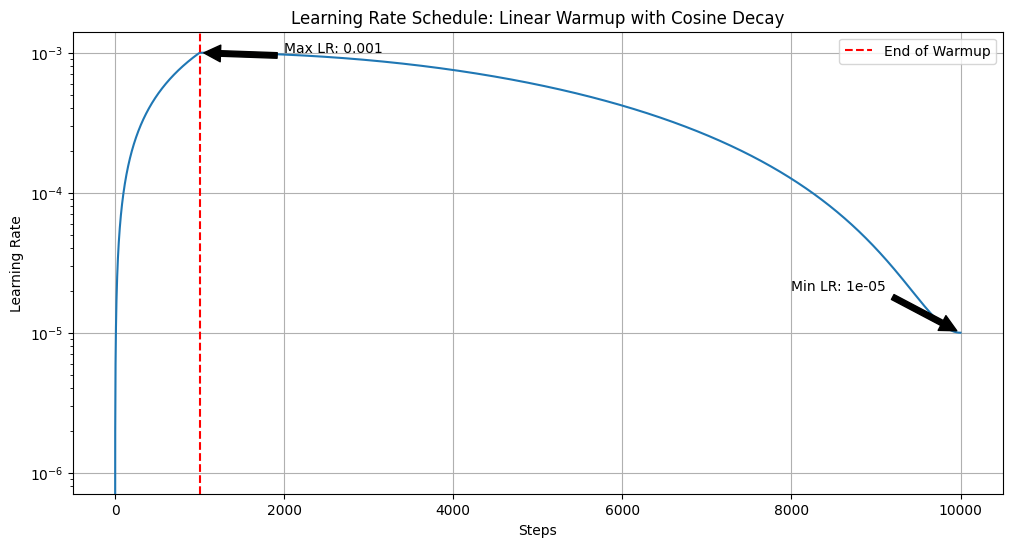

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
def get_lr_with_cosine_decay_and_warmup(step, total_steps, max_lr, min_lr, warmup_steps):
    """
    Calculate learning rate using cosine decay with linear warmup.
    
    Args:
    step (int): Current step in training.
    total_steps (int): Total number of training steps.
    max_lr (float): Maximum learning rate (peak after warmup).
    min_lr (float): Minimum learning rate (at the end of training).
    warmup_steps (int): Number of warmup steps.
    
    Returns:
    float: Current learning rate.
    """
    def warmup(s):
        return max_lr * (s / warmup_steps)
    
    def cosine_decay(s):
        progress = (s - warmup_steps) / (total_steps - warmup_steps)
        return min_lr + 0.5 * (max_lr - min_lr) * (1 + jnp.cos(jnp.pi * progress))
    
    return jax.lax.cond(
        step < warmup_steps,
        warmup,
        cosine_decay,
        step
    )

def visualize_lr_schedule(total_steps, warmup_steps, max_lr, min_lr):
    steps = np.arange(total_steps)
    compiled_get_lr = jax.jit(get_lr_with_cosine_decay_and_warmup).lower(0, total_steps, max_lr, min_lr, warmup_steps).compile()
    lrs = [compiled_get_lr(step, total_steps, max_lr, min_lr, warmup_steps) for step in steps]

    plt.figure(figsize=(12, 6))
    plt.plot(steps, lrs)
    plt.title('Learning Rate Schedule: Linear Warmup with Cosine Decay')
    plt.xlabel('Steps')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
    plt.grid(True)

    # Highlight warmup period
    plt.axvline(x=warmup_steps, color='r', linestyle='--', label='End of Warmup')
    
    # Annotate max and min learning rates
    plt.annotate(f'Max LR: {max_lr}', xy=(warmup_steps, max_lr), xytext=(warmup_steps+0.1*total_steps, max_lr),
                 arrowprops=dict(facecolor='black', shrink=0.05))
    plt.annotate(f'Min LR: {min_lr}', xy=(total_steps-1, min_lr), xytext=(total_steps*0.8, min_lr*2),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.legend()
    plt.show()

total_steps = 10000
warmup_steps = 1000
max_lr = 1e-3
min_lr = 1e-5

visualize_lr_schedule(total_steps, warmup_steps, max_lr, min_lr)